In [65]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import osascript
from gtts import gTTS 
import os 
import pyaudio
import wave
import keyboard  # using module keyboard
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Extract data
for this part we extract the wave file as well as the meta data. the data file has two channels that we are going to clean up before we use. 

In [150]:
fs, data = wavfile.read('./LDC2002S28.wav')
number_of_samples = data.shape[0]
meta_data = open(r"LDC2002S28-txt.txt")
meta_data = pd.read_csv("LDC2002S28-txt.txt", sep="A:", header=None, engine='python')
meta_data.columns = ["sound limits","description"]

In [151]:
data = np.average(data, axis = 1)

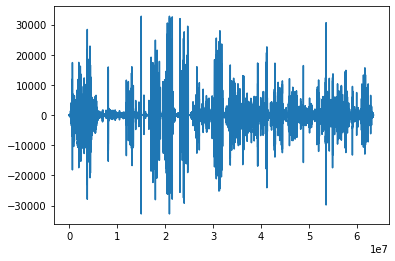

In [152]:
plt.plot(data)

# High pass filter
used a high pass filter to clean the noise from the dc signal setting the lowest frequeency possible to be 10 hz

In [153]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

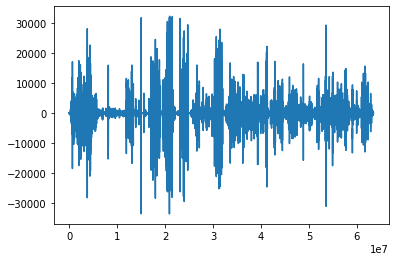

In [154]:
data = butter_highpass_filter(data, 10, fs)
plt.plot(data)

# divide the data

In [155]:
voice_time_limits = meta_data["sound limits"]

voice_time_limits = [i.split(" ")[0:2] for i in voice_time_limits]
voice_time_limits = np.array(voice_time_limits)
voice_time_limits = voice_time_limits.astype(np.float)


In [156]:
data_number = 0
divided_data = []
for i in voice_time_limits:
    startingpoint = int(i[0]*fs)
    endingpoint = int(i[1]*fs)
    divided_data.append(data[startingpoint:endingpoint])
    data_number +=1
    

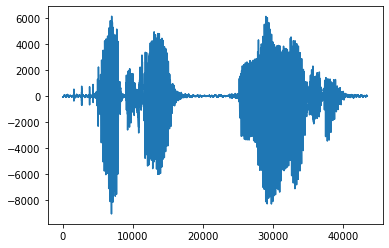

In [157]:
plt.plot(divided_data[1])

In [158]:
np.save("segmented_voice_data",divided_data)

# accepting input

In [ ]:
def input(voice_data):
    fs, data = wavfile.read(voice_data)
    number_of_samples = data.shape[0]
    data = np.average(data, axis = 1)
    data = butter_highpass_filter(data, 10, fs)
    plt.plot(data)

# process the voice

In [213]:
#ronak give back ussr volume

# setting the volume


speaker volume is 100
user volume is 20
speaker new volume is 36.0


In [76]:
from sys import byteorder
from array import array
from struct import pack

import pyaudio
import wave

THRESHOLD = 600
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 44100

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 60:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
def reply(user_volume):
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    print("speaker volume is " + str(speaker_volume))
    print("user volume is "+str(user_volume))
    if(speaker_volume < user_volume):
        new_volume = speaker_volume + (((speaker_volume - user_volume)**2) /100)
    else:
        new_volume = speaker_volume - (((speaker_volume - user_volume)**2) /100)
    print("speaker new volume is "+str(new_volume))
    osascript.osascript("set volume output volume "+str(new_volume)) 
    thing_to_say = 'hello, your volume is at'+str(int(new_volume))
    os.system("say "+thing_to_say)
def voice_input(voice_data):
    fs, data = wavfile.read(voice_data)
    plt.plot(data)
    number_of_samples = data.shape
    plt.plot(data)
    print(data)
    data = butter_highpass_filter(data, 10, fs)
    return data

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    print(b,a,data)
    y = signal.filtfilt(b, a, data)
    return y
def remove_silence_from(amplitudes, threshold):
    silenced = []
    for x in amplitudes:
        if x >= threshold:
            silenced.append(x)
    return silenced
def get_loudness_stats(data):
    divided_data = data
    # Average data to step size
    avg_step = 400
    avg_data = np.mean(divided_data[:(len(divided_data)//avg_step)*avg_step].reshape(-1,avg_step), axis=1)
    #apply envelope
    hilbert_transformed = np.abs(scipy.signal.hilbert(avg_data))

    plt.figure(0)
    plt.plot(hilbert_transformed, label = "envelope")
    plt.plot(avg_data)


    #remove silence 
    avg = np.mean(hilbert_transformed);
    silence_factor = 3
    silenced = remove_silence_from(avg_data, avg/silence_factor)
    plt.figure(1)
    plt.plot(silenced)

    #return mean and median
    mean = np.mean(silenced)
    median = np.median(silenced)

    return mean, median


[0 0 0 ... 0 0 0]
[ 0.99769735 -4.98848674  9.97697347 -9.97697347  4.98848674 -0.99769735] [ 1.         -4.99538938  9.98156817 -9.97236817  4.98158939 -0.9954    ] [0 0 0 ... 0 0 0]


(142.97532630174672, 111.87624274858804)

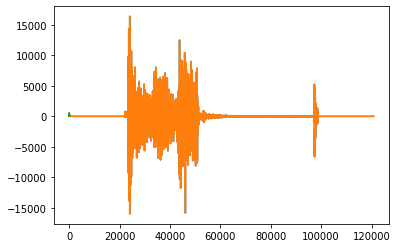

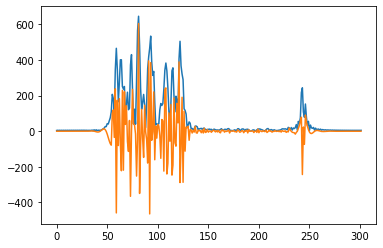

please speak a word into the microphone
done - result written to demo.wav
[0 0 0 ... 0 0 0]
[ 0.99769735 -4.98848674  9.97697347 -9.97697347  4.98848674 -0.99769735] [ 1.         -4.99538938  9.98156817 -9.97236817  4.98158939 -0.9954    ] [0 0 0 ... 0 0 0]
speaker volume is 100
user volume is 29.242728341132356
speaker new volume is 49.93408507393207


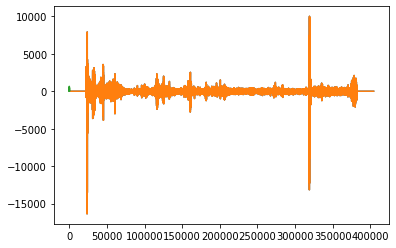

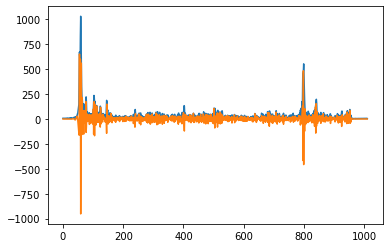

In [81]:

if __name__ == '__main__':
    print("please speak a word into the microphone")
    record_to_file('demo.wav')
    print("done - result written to demo.wav")
    data = voice_input('demo.wav')
    new_volume = get_loudness_stats(data)
    reply(new_volume[1])